# Imports

In [1]:
!python -m spacy download en_core_web_md
# spacy has a simple UX and can be used for simple tasks

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 162.5 kB/s eta 0:04:24
     --------------------------------------- 0.0/42.8 MB 279.3 kB/s eta 0:02:34
     --------------------------------------- 0.1/42.8 MB 599.1 kB/s eta 0:01:12
     --------------------------------------- 0.1/42.8 MB 566.5 kB/s eta 0:01:16
     --------------------------------------- 0.2/42.8 MB 573.4 kB/s eta 0:01:15
     --------------------------------------- 0.2/42.8 MB 560.2 kB/s eta 0:01:17
     --------------------------------------- 0.2/42.8 MB 573.4 kB/s eta 0:01:15
     --------------------------------------- 0.3/42.8 MB 561.1 kB/s eta 0:01:16
     --------------------------------------- 0.3/42.8 MB 548.9 kB/s eta 0:01:18
     --------------------------------------- 0.3/42.8 MB 558.2 k


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import spacy
import pandas as pd
import numpy as np
import string

from tqdm import tqdm
tqdm.pandas()


# Input data

All of the input data is text from annual reports, regulations, and other corpus. What we want to do is see if we can detect some `greenwashing` in the text. This will be done with a classifier to detect the subject and then if the subject is greenwashing or not.

In [3]:
df = pd.read_csv("https://media.githubusercontent.com/media/JosPolfliet/vlerick-mai-nlp-2023/main/DATA/esg_reports.csv")
df["subject"] = df["subject"].fillna("Other")
df

,text,subject
0,"Since its inception in 2010, we have distribut...",Social
1,"I will focus first on traffic, which is a key ...",Other
2,"Also, many farms are aged with degraded soil t...",Environmental
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social
4,The company’s U.S. GOM operations can be impac...,Other
...,...,...
2180,American shad are a species of concern for res...,Environmental
2181,Weyerhaeuser's policies address best practices...,Other
2182,compares recently observed trends in weather p...,Environmental
2183,"If our partners, including our licensors, suff...",Other


In [4]:
df.head()

,text,subject
0,"Since its inception in 2010, we have distribut...",Social
1,"I will focus first on traffic, which is a key ...",Other
2,"Also, many farms are aged with degraded soil t...",Environmental
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social
4,The company’s U.S. GOM operations can be impac...,Other


## Get data

In [7]:
for i in range(10,15):
    print(i, df.iloc[i]["subject"],">", df.iloc[i]["text"])
    # print(df.iloc[i])

10 Social > We worked closely with our portfolio companies to provide valuable resources to support their growth and enable opportunities within the Salesforce ecosystem.
11 Social > His typical day includes customer calls and visits, following up on referrals and planning for future lakeshore banking services.
12 Environmental > Climate Adaptation Market: A large part of our product portfolio helps address global challenges: food availability; energy supply; climate change and energy efficiency; water availability and quality; nature, natural capital, ecosystem services and biodiversity; and human health.
13 Other > In determining fair value for land held for sale, management considers, among other things, prices for land in recent comparable sale transactions, market analysis studies, which include the estimated price a willing buyer would pay for the land (other than in a forced liquidation sale) and recent bona fide offers received from outside third parties.
14 Social > More than 

We'll use the following example sentence

In [8]:
sentence = df.iloc[67]
sentence.text

'Our Logistics We maintain a full-line wholesale and logistics facility in Alabaster, Alabama (a suburb of Birmingham) where we receive and ship most our merchandise.'

## Clean data

In [26]:
# Get everything to lower case
temp = sentence.text.lower()

# Split the sentence
# temp = temp.split()
nlp = spacy.load("en_core_web_md")
for token in nlp(temp):
    print(token.text, token.lemma_)

our our
logistics logistic
we we
maintain maintain
a a
full full
- -
line line
wholesale wholesale
and and
logistics logistic
facility facility
in in
alabaster alabaster
, ,
alabama alabama
( (
a a
suburb suburb
of of
birmingham birmingham
) )
where where
we we
receive receive
and and
ship ship
most most
our our
merchandise merchandise
. .


In [14]:
punctuations = string.punctuation

nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence["text"].lower())

    # Remove OOV words
    mytokens = [ word for word in mytokens if not word.is_oov ]

    # Lemmatise + lower case
    mytokens = [ word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

spacy_tokenizer(sentence)

['logistic',
 'maintain',
 'line',
 'wholesale',
 'logistic',
 'facility',
 'alabaster',
 'alabama',
 'suburb',
 'birmingham',
 'receive',
 'ship',
 'merchandise']

## Calculate word frequencies

In [15]:
from collections import Counter

tokenFreq = Counter()

def countWordFrequencies(example):
    tokens = spacy_tokenizer(example)
    tokenFreq.update(tokens)

_ = df.progress_apply(countWordFrequencies, axis=1)


100%|██████████| 2185/2185 [00:23<00:00, 91.07it/s] 


0       None
1       None
2       None
3       None
4       None
        ... 
2180    None
2181    None
2182    None
2183    None
2184    None
Length: 2185, dtype: object

In [18]:
tokenFreq.total()
print(f"We have about {tokenFreq.total()/df.shape[0]:.1f} tokens per example in our corpus")

We have about 17.9 tokens per example in our corpus


In [21]:
print(f"We have {len(tokenFreq.keys())} unique tokens in our corpus")

We have 5529 unique tokens in our corpus


In [22]:
# We will then only keep the words that occur most frequently
VOCAB_SIZE = 1000

In [23]:
print("Most frequent")
print(tokenFreq.most_common(10))
print("Least frequent")
print(tokenFreq.most_common(VOCAB_SIZE)[-10:])


Most frequent
[('water', 527), ('use', 320), ('include', 298), ('energy', 275), ('company', 232), ('forest', 229), ('environmental', 223), ('product', 213), ('management', 178), ('operation', 162)]
Least frequent
[('relevant', 8), ('80', 8), ('livestock', 8), ('insect', 8), ('tenant', 8), ('cocoa', 8), ('recover', 8), ('borrower', 8), ('disturbance', 8), ('contribution', 8)]


In [38]:
tokenMap = {k: i+1 for i, (k, _) in enumerate(tokenFreq.most_common(VOCAB_SIZE-1))}
# we leave one for the out of vocabulary token
tokenMap["<oov>"]=0
tokenMapInverse = {v: k for k,v in tokenMap.items()}
print(list(tokenMap.items())[0:10])
print([tokenMapInverse[i] for i in range(10)])

tokenMapInverse

[('water', 1), ('use', 2), ('include', 3), ('energy', 4), ('company', 5), ('forest', 6), ('environmental', 7), ('product', 8), ('management', 9), ('operation', 10)]
['<oov>', 'water', 'use', 'include', 'energy', 'company', 'forest', 'environmental', 'product', 'management']


{1: 'water',
 2: 'use',
 3: 'include',
 4: 'energy',
 5: 'company',
 6: 'forest',
 7: 'environmental',
 8: 'product',
 9: 'management',
 10: 'operation',
 11: 'material',
 12: 'business',
 13: 'work',
 14: 'reduce',
 15: '�',
 16: 'project',
 17: 'impact',
 18: 'source',
 19: 'year',
 20: 'new',
 21: 'increase',
 22: 'sustainable',
 23: 'area',
 24: 'provide',
 25: 'service',
 26: 'community',
 27: 'biodiversity',
 28: 'conservation',
 29: 'natural',
 30: 'program',
 31: 'support',
 32: 'emission',
 33: 'risk',
 34: 'waste',
 35: 'change',
 36: 'oil',
 37: 'land',
 38: 'resource',
 39: 'habitat',
 40: 'renewable',
 41: 'environment',
 42: 'tree',
 43: 'million',
 44: 'gas',
 45: 'development',
 46: 'result',
 47: 'manage',
 48: 'wildlife',
 49: 'market',
 50: 'site',
 51: 'help',
 52: 'facility',
 53: 'percent',
 54: 'local',
 55: 'protect',
 56: 'wood',
 57: 'paper',
 58: 'continue',
 59: 'specie',
 60: 'develop',
 61: 'supply',
 62: 'base',
 63: 'practice',
 64: 'system',
 65: 'carbo

## Simple model - BOW

In [39]:


example = df.iloc[5]

embedding = np.zeros(VOCAB_SIZE)
tokens = spacy_tokenizer(example)
for token in tokens:
    if token in tokenMap:
        embedding[tokenMap[token]] += 1
    else:
        embedding[0] += 1

embedding

array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [36]:
def embed_sentence_BOW(example):
    """
    Simple BOW
    """
    embedding = np.zeros(VOCAB_SIZE)
    tokens = spacy_tokenizer(example)
    for token in tokens:
        try:
            tokenIndex = tokenMap[token]
        except KeyError: # Out of vocabulary
            tokenIndex = 0
        embedding[tokenIndex] = embedding[tokenIndex] + 1
    return embedding

sentence = df.iloc[302]
sentence_embedding = embed_sentence_BOW(sentence)

# print(sentence_embedding)
print(sentence_embedding.shape)
print(sentence.text)
print("What this means: ")

for i in range(VOCAB_SIZE):
    if sentence_embedding[i]:
        print(f"Token {i} '{tokenMapInverse[i]}' occurs {sentence_embedding[i]} time in sentence.")

(1000,)
It also cultivates open collaborative innovation with the startup ecosystem.
What this means: 
Token 0 '<oov>' occurs 2.0 time in sentence.
Token 67 'ecosystem' occurs 1.0 time in sentence.
Token 394 'cultivate' occurs 1.0 time in sentence.
Token 573 'innovation' occurs 1.0 time in sentence.
Token 682 'open' occurs 1.0 time in sentence.


In [40]:
df["embedding"] = df.progress_apply(embed_sentence_BOW, axis=1)
df

100%|██████████| 2185/2185 [00:34<00:00, 63.53it/s]


,text,subject,embedding
0,"Since its inception in 2010, we have distribut...",Social,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"I will focus first on traffic, which is a key ...",Other,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"Also, many farms are aged with degraded soil t...",Environmental,"[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social,"[7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,The company’s U.S. GOM operations can be impac...,Other,"[9.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
2180,American shad are a species of concern for res...,Environmental,"[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2181,Weyerhaeuser's policies address best practices...,Other,"[6.0, 0.0, 1.0, 3.0, 0.0, 1.0, 3.0, 0.0, 1.0, ..."
2182,compares recently observed trends in weather p...,Environmental,"[5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2183,"If our partners, including our licensors, suff...",Other,"[3.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


## Classify

In [41]:
X = np.stack(df["embedding"])
X.shape

(2185, 1000)

In [42]:
X[302:303,]

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [43]:
y = np.array(df["subject"])
y

array(['Social', 'Other', 'Environmental', ..., 'Environmental', 'Other',
       'Other'], dtype=object)

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22141)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (1638, 1000)
X_test shape: (547, 1000)
y_train shape: (1638,)
y_test shape: (547,)


In [46]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=22141, class_weight="balanced", n_estimators=300)
clf.fit(X_train, y_train)

print("Done")

Done
CPU times: total: 1.2 s
Wall time: 3.38 s


## Evaluate

In [47]:
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from matplotlib import pyplot as plt
import datetime
from tabulate import tabulate

def log_experiment_results(experiment_name, stats, filename="experiment_log.md"):
    """
    Appends experiment results and statistics to a markdown log file.

    Parameters:
    - experiment_name: str, the name of the experiment
    - stats: dict, a dictionary containing the statistics to log
    - filename: str, the path to the log file
    """
    stats["timestamp"] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
    stats["Experiment Name"] = experiment_name
    try:

        df = pd.read_table(filename, sep="|", skipinitialspace=True).drop(0)
        df.columns = df.columns.str.strip()
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    except (FileNotFoundError, pd.errors.EmptyDataError, pd.errors.ParserError):
        df = pd.DataFrame(columns=list(stats.keys()))

    df = pd.concat([df, pd.DataFrame([stats])], ignore_index=True)
    df = df[["precision", "recall", "f1-score", "support", "timestamp", "Experiment Name"]]
    markdown_table = tabulate(df, headers='keys', tablefmt='pipe', showindex=False, floatfmt=(".3g"), intfmt=",")
    with open(filename, 'w') as f:
        f.write(markdown_table)

def evaluate_model(y_test, predictions, clf):
    stats = classification_report(y_test, predictions, output_dict=True)
    print(classification_report(y_test, predictions))

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, predictions),
        display_labels=clf.classes_,
    )

    cmp.plot(ax=ax)
    plt.show()
    return stats

               precision    recall  f1-score   support

Environmental       0.86      0.64      0.73       299
        Other       0.69      0.58      0.63       115
       Social       0.45      0.77      0.57       133

     accuracy                           0.66       547
    macro avg       0.67      0.67      0.65       547
 weighted avg       0.73      0.66      0.67       547



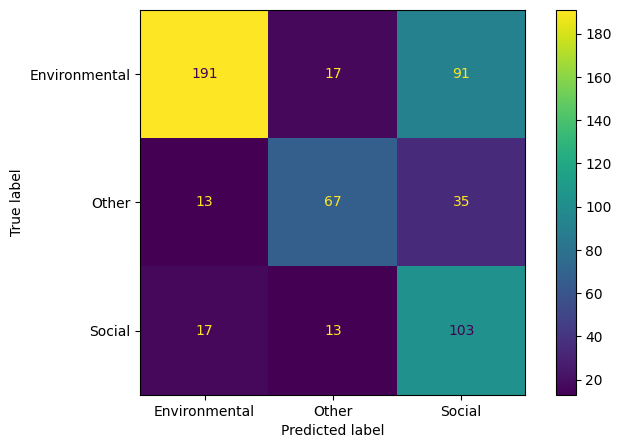

In [48]:
experiment_name = input("Enter experiment name: ")
predictions = clf.predict(X_test)
stats = evaluate_model(y_test, predictions, clf)
log_experiment_results(experiment_name, stats["macro avg"])

## What's next?
### Fundamental limitations of the BOW approach
1. We're just counting words, which means we don't consider the order of words in a sentence.
2. Lots of OOV tokens that are modelled incorrectly, which we don't like.
3. We are using every word with equal weight, while some words are more important than others
